In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
print(os.listdir('./input'))

['sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
# data read
data_all = pd.read_csv('./input/train.csv', dtype=np.float32)
# data image, normalize
data_image = data_all.drop('label', axis=1).values
# data label
data_label = data_all['label'].values

In [3]:
# train(0.8) test(0.2) split
train_image, test_image, train_label, test_label = \
    train_test_split(data_image, data_label, test_size=0.2)
# len(data_image) = len(train_image) + len(test_image)
print('Total: {} '.format(len(data_image)),
      'Train: {} '.format(len(train_image)),
      'Test: {} '.format(len(test_image)))

Total: 42000  Train: 33600  Test: 8400 


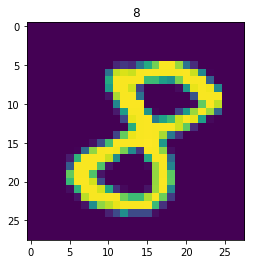

In [4]:
# image show
plt.imshow(train_image[0].reshape(28,28))
plt.title(int(train_label[0]))
plt.show()

In [5]:
import torch
# train data to tensor with normalize
train_image = torch.from_numpy(train_image).type(torch.FloatTensor)/255
train_label = torch.from_numpy(train_label).type(torch.LongTensor)
# test data to tensor with normalize
test_image = torch.from_numpy(test_image).type(torch.FloatTensor)/255
test_label = torch.from_numpy(test_label).type(torch.LongTensor)

In [6]:
# hyperparameters
batch_size = 100
num_iters = 2500
num_epochs = int(num_iters / (len(train_image) / batch_size))
print(num_epochs)

7


In [7]:
from torch.utils.data import DataLoader, TensorDataset
# image & label set
train = TensorDataset(train_image, train_label)
test = TensorDataset(test_image, test_label)
# data loader
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [8]:
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [9]:
# CNN model
class CNN(nn.Module):
    def __init__(self):
        # Module initialize
        super(CNN, self).__init__()
        # (100,1,28,28) -> (100,16,24,24)
        self.cn1 = nn.Conv2d(in_channels=1, out_channels=16,
                              kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        # (100,16,24,24) -> (100,16,12,12)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # (100,16,12,12) -> (100,32,8,8)
        self.cn2 = nn.Conv2d(in_channels=16, out_channels=32,
                              kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        # (100,32,8,8) -> (100,32,4,4)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # (100,32*4*4) -> (100,10)
        self.fc1 = nn.Linear(32 * 4 * 4, 10)
    
    def forward(self, x):
        x = self.maxpool1(self.relu1(self.cn1(x)))
        x = self.maxpool2(self.relu2(self.cn2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [10]:
# model, loss, optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06, momentum=0.1)

In [11]:
loss_list = []
accuracy_list = []
iter_list = []
iter_cnt = 0

# train 
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(batch_size,1,28,28))
        labels = Variable(labels)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        iter_cnt += 1
        
        # test for every 50 iters
        if iter_cnt % 50 == 0:
            with torch.no_grad():
                accuracy = 0
                total = 0
                for images, labels in test_loader:
                    images = Variable(images.view(batch_size,1,28,28))
                    outputs = model(images)
                    predict = torch.max(outputs.data, 1)[1]
                    total += len(labels)
                    accuracy += float((labels == predict).sum())
                accuracy = 100 * accuracy / total
                
                loss_list.append(loss.data)
                iter_list.append(iter_cnt)
                accuracy_list.append(accuracy)
                
                # print epoch, accuracy every 500 iters
                if iter_cnt % 500 == 0:
                    print('Epoch: {}'.format(iter_cnt),
                          'Loss: {:.3f}'.format(loss.data),
                          'Accuracy: {:.3f} %'.format(accuracy))

Epoch: 500 Loss: 0.144 Accuracy: 96.333 %
Epoch: 1000 Loss: 0.046 Accuracy: 97.357 %
Epoch: 1500 Loss: 0.103 Accuracy: 97.452 %
Epoch: 2000 Loss: 0.066 Accuracy: 97.738 %


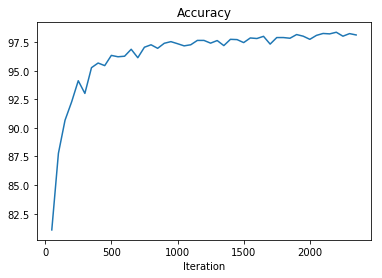

In [12]:
# visualization accuracy
plt.plot(iter_list, accuracy_list)
plt.xlabel('Iteration')
plt.title('Accuracy')
plt.show()

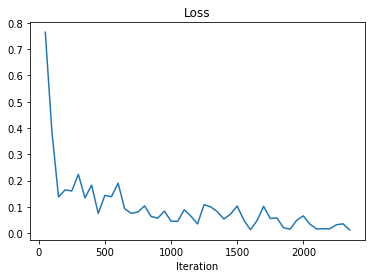

In [13]:
# visualization loss
plt.plot(iter_list, loss_list)
plt.xlabel('Iteration')
plt.title('Loss')
plt.show()

In [14]:
# save model
print('save model state dict keys: \n', model.state_dict().keys())
torch.save(model.state_dict(), 'checkpoint.pth')

save model state dict keys: 
 odict_keys(['cn1.weight', 'cn1.bias', 'cn2.weight', 'cn2.bias', 'fc1.weight', 'fc1.bias'])


In [15]:
# load model
state_dict = torch.load('checkpoint.pth')
print('load model state dict keys: \n', model.state_dict().keys())

load model state dict keys: 
 odict_keys(['cn1.weight', 'cn1.bias', 'cn2.weight', 'cn2.bias', 'fc1.weight', 'fc1.bias'])


In [16]:
# load test data
new_test = pd.read_csv('./input/test.csv').values
new_images = torch.from_numpy(new_test).type(torch.FloatTensor)/255
print(new_images.shape)
new_test_loader = DataLoader(new_images, batch_size=batch_size, shuffle=False)

torch.Size([28000, 784])


In [17]:
results = []
with torch.no_grad():
    model.eval()
    for images in new_test_loader:
        images = Variable(images.view(batch_size,1,28,28))
        outputs = model(images)
        predict = torch.max(outputs.data, 1)[1]
        results += predict.numpy().tolist()
        
print(results[:10])
print(len(results))

[2, 0, 9, 9, 3, 7, 0, 3, 0, 3]
28000


In [18]:
results = np.array(results).flatten()
print(results[:10])
print(results.shape)

[2 0 9 9 3 7 0 3 0 3]
(28000,)


In [19]:
# submit
submissions = pd.DataFrame({'ImageId': list(range(1, len(results)+1)),
                          'Label': results})
submissions.to_csv('submissions.csv', index=False, header=True)
# check
print(submissions[:10])

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3
5        6      7
6        7      0
7        8      3
8        9      0
9       10      3
